In [1]:
import os
import sys
import numpy as np
from skimage import io
import itk
from scipy import ndimage
import matplotlib
from matplotlib import pyplot as plt

In [2]:
def compare_two_images(img1, img2):
    plt.figure(figsize=[20,20])
    plt.imshow(img1,cmap='Blues')
    plt.imshow(img2,alpha=0.5,cmap='Reds')
    
def compute_dice_coefficient(source_image: itk.Image, target_image: itk.Image) -> float:
    """Compute the dice coefficient to compare volume overlap between two label regions"""
    dice_filter = itk.LabelOverlapMeasuresImageFilter[type(source_image)].New()
    dice_filter.SetInput(source_image)
    dice_filter.SetTargetImage(target_image)
    dice_filter.Update()
    return dice_filter.GetDiceCoefficient()

In [3]:
DATA = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52/preps/CH1'
REGDATA = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'

In [4]:
filename = 'allen_25um_sagittal.tif'
fixedFilepath = os.path.join(REGDATA, filename)
fixed_volume = io.imread(fixedFilepath)
print(f'Fixed volume shape={fixed_volume.shape} dtype={fixed_volume.dtype}')
#fixed_volume = itk.imread(fixedFilepath, itk.F)

Fixed volume shape=(456, 320, 528) dtype=uint16


In [5]:
#colpad = np.zeros((fixed_volume.shape[0], fixed_volume.shape[1], 100), np.uint16)
#print(f'colspad shape={colpad.shape}')
#fixed_volume = np.concatenate((fixed_volume, colpad), axis=2)
#rowpad = np.zeros((fixed_volume.shape[0], 50, fixed_volume.shape[2]), np.uint16)
#print(f'rowpad shape={rowpad.shape}')
#fixed_volume = np.concatenate((fixed_volume, rowpad), axis=1)
#print(f'Fixed volume after padding shape={fixed_volume.shape} dtype={fixed_volume.dtype}')

In [6]:
#outpath = os.path.join(REGDATA, 'allen_25um_sagittal_padded.tif')
#imwrite(outpath, fixed_volume)

In [7]:
fixed_midpoint = fixed_volume.shape[0] // 2
fixed_image = fixed_volume[fixed_midpoint,:,:]
del fixed_volume
print(f'Fixed image shape={fixed_image.shape} dtype={fixed_image.dtype}')

Fixed image shape=(320, 528) dtype=uint16


In [8]:
scale = 64
# moving_volume around x=1200, y = 750 for 10um
# moving volume around x=600, y=350 for 25um
files = sorted(os.listdir(os.path.join(DATA, f'thumbnail_aligned.{scale}')))
midpoint = len(files) // 2
filename = f'{files[midpoint]}'
movingFilepath = os.path.join(DATA, f'thumbnail_aligned.{scale}', filename)
moving_image = io.imread(movingFilepath)
print(f'Moving image: {filename} shape={moving_image.shape} dtype={moving_image.dtype}')

Moving image: 242.tif shape=(555, 1024) dtype=uint16


In [9]:
movingImage = itk.GetImageFromArray(np.ascontiguousarray(moving_image.astype(np.float32)))
fixedImage = itk.GetImageFromArray(np.ascontiguousarray(fixed_image.astype(np.float32)))

In [21]:
um = 25
parameter_object = itk.ParameterObject.New()
trans_parameter_map = parameter_object.GetDefaultParameterMap('translation')
rigid_parameter_map = parameter_object.GetDefaultParameterMap('rigid')
affine_parameter_map = parameter_object.GetDefaultParameterMap('affine')
# For the bspline default parameter map, an extra argument can be specified that define the 
#final bspline grid spacing in physical space. 

bspline_parameter_map = parameter_object.GetDefaultParameterMap("bspline")
bspline_parameter_map["FinalGridSpacingInVoxels"] = (f"{um}",f"{um}")
parameter_object.AddParameterMap(trans_parameter_map)
parameter_object.AddParameterMap(rigid_parameter_map)
parameter_object.AddParameterMap(affine_parameter_map)
parameter_object.AddParameterMap(bspline_parameter_map)
parameter_object.SetParameter("ResultImageFormat", "tif")
# here the 'DefaultPixelValue' of all parameter maps is in the parameter_object set to 0

#parameter_object.SetParameter(3, "FinalGridSpacingInPhysicalUnits", "10")
parameter_object.RemoveParameter("FinalGridSpacingInPhysicalUnits")

In [11]:
#print(parameter_object)

In [22]:
%%time
# Load Elastix Image Filter Object
elastix_object = itk.ElastixRegistrationMethod.New(fixedImage, movingImage)
elastix_object.SetParameterObject(parameter_object)
# Set additional options
elastix_object.SetLogToConsole(False)
# Update filter object (required)
elastix_object.UpdateLargestPossibleRegion()
# Results of Registration
resultImage = elastix_object.GetOutput()
result_transform_parameters = elastix_object.GetTransformParameterObject()

CPU times: user 25.1 s, sys: 2.85 s, total: 28 s
Wall time: 4.6 s


In [42]:
#init_transform = itk.transformread(result_transform_parameters)[0]
#print(init_transform)

In [29]:
print(type(resultImage))
print(type(fixedImage))

<class 'itk.itkImagePython.itkImageF2'>
<class 'itk.itkImagePython.itkImageF2'>


In [14]:
#registered_image = np.asarray(resultImage).astype(np.uint16)
#print(f'image dtype={registered_image.dtype} shape={registered_image.shape}')

In [38]:
Dimension = 2
InputPixelType = itk.F
OutputPixelType = itk.UC

InputImageType = itk.Image[InputPixelType, Dimension]
OutputImageType = itk.Image[OutputPixelType, Dimension]

castImageFilter = itk.CastImageFilter[InputImageType, OutputImageType].New()
rescaler = itk.RescaleIntensityImageFilter[InputImageType, InputImageType].New()
rescaler.SetInput(fixedImage)
rescaler.SetOutputMinimum(0)
outputPixelTypeMaximum = itk.NumericTraits[OutputPixelType].max()
rescaler.SetOutputMaximum(outputPixelTypeMaximum)
castImageFilter.SetInput(rescaler.GetOutput())
targetImage = castImageFilter.GetOutput()

castImageFilterS = itk.CastImageFilter[InputImageType, OutputImageType].New()
rescalerS = itk.RescaleIntensityImageFilter[InputImageType, InputImageType].New()
rescalerS.SetInput(resultImage)
rescalerS.SetOutputMinimum(0)
outputPixelTypeMaximum = itk.NumericTraits[OutputPixelType].max()
rescalerS.SetOutputMaximum(outputPixelTypeMaximum)
castImageFilterS.SetInput(rescalerS.GetOutput())
sourceImage = castImageFilterS.GetOutput()

dice_score = compute_dice_coefficient(sourceImage, targetImage)
print(f'Evaluated dice value: {dice_score}')

Evaluated dice value: 0.003852684048271038


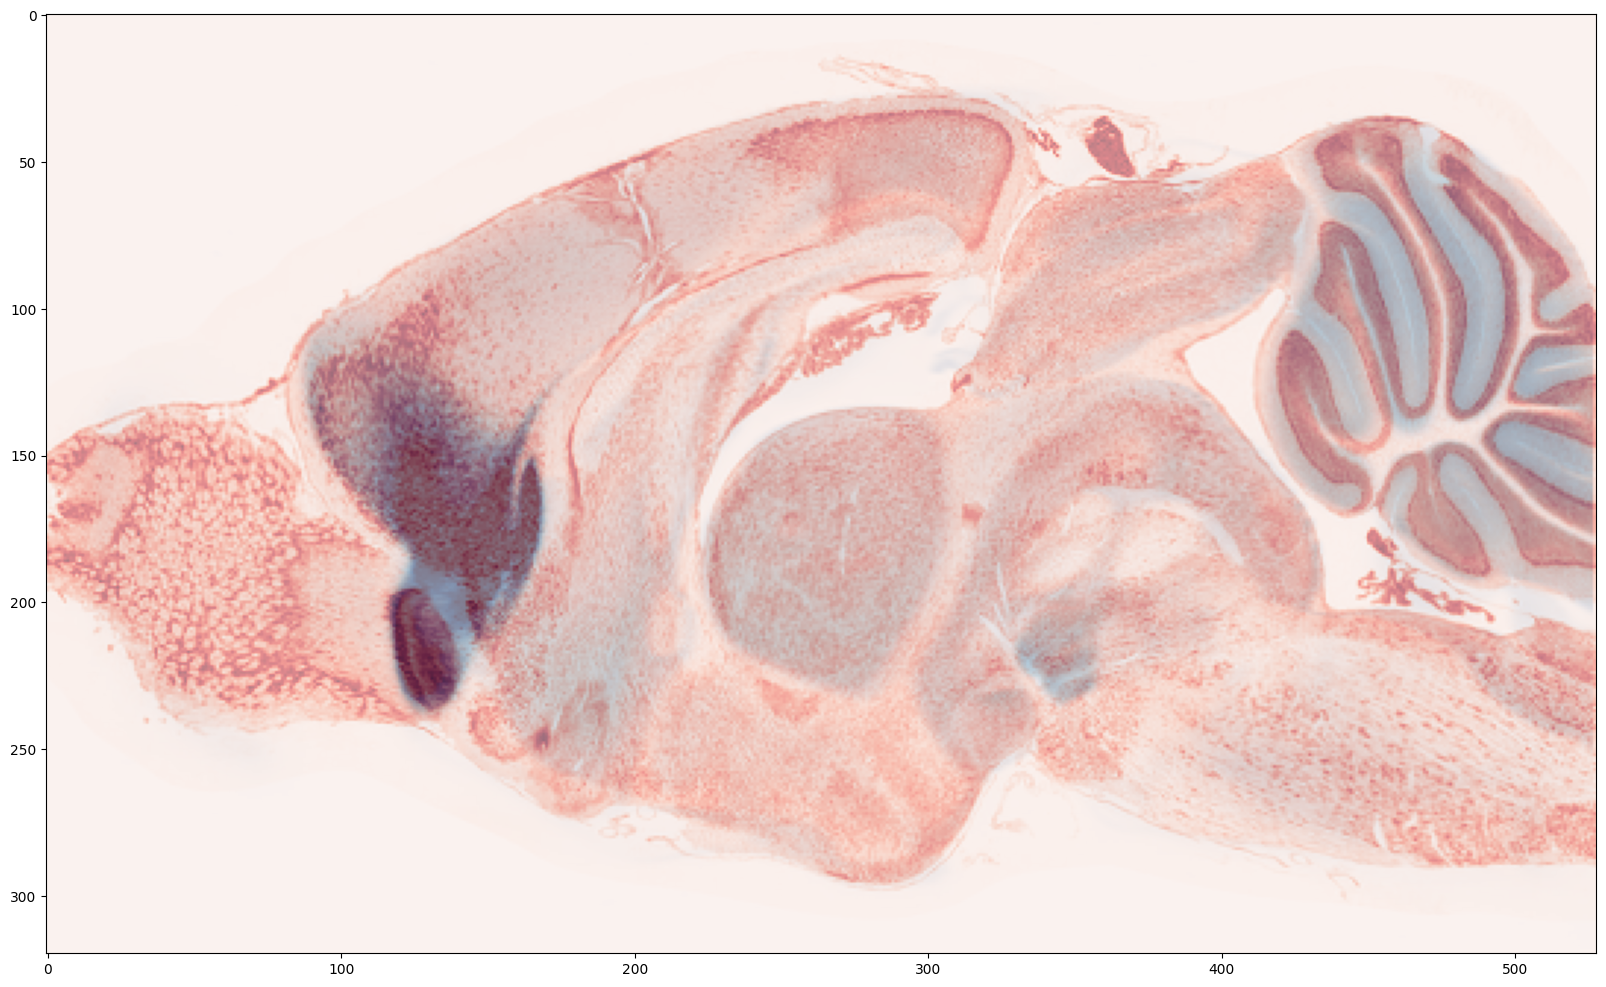

In [39]:
# 1- blue is fixed (Allen), 2 red is moving (DKXX)
compare_two_images(targetImage, sourceImage)

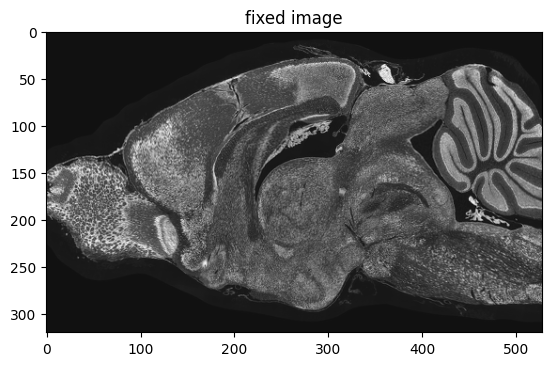

In [35]:
plt.title('fixed image')
plt.imshow(resultImage, cmap="gray")
plt.show()

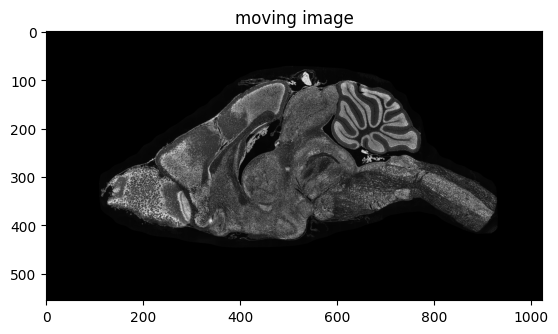

In [18]:
#ri = sitk.GetArrayFromImage(registered_image)
plt.title('moving image')
plt.imshow(movingImage, cmap="gray")
plt.show()

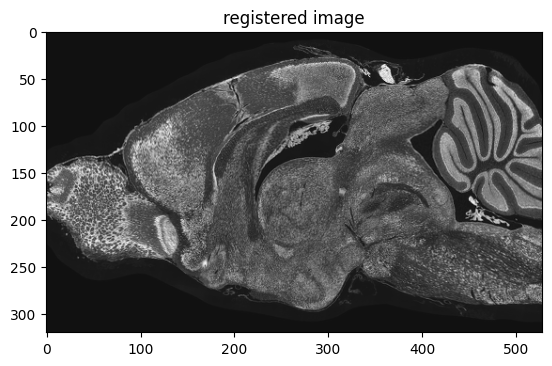

In [31]:
plt.title('registered image')
plt.imshow(resultImage, cmap="gray")
plt.show()

In [20]:
input_points = itk.PointSet[itk.F, 3].New()

for point_id, point in enumerate(points_markup["markups"][0]["controlPoints"]):
    input_points.GetPoints().InsertElement(point_id, point["position"])

print(input_points.GetPoint(0))
print(input_points)